In [1]:
# Basic libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List

In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


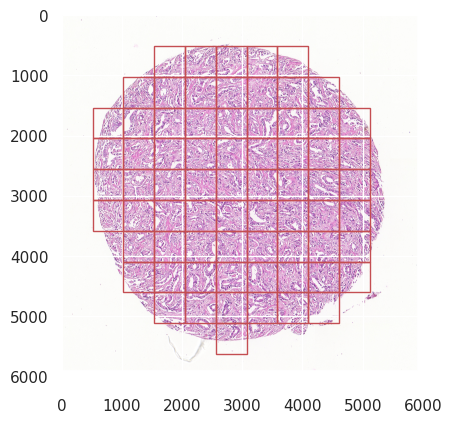

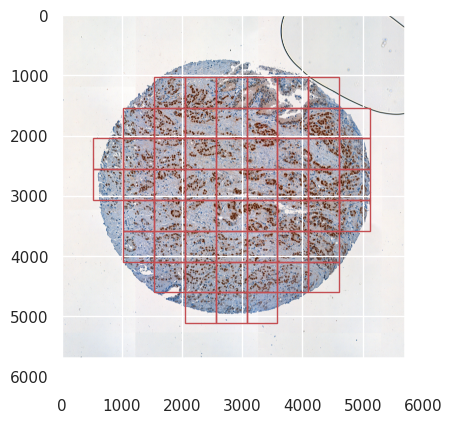

In [5]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

In [6]:
test_patch_src = patches_src[10]
test_patch_dst = patches_dst[10]

In [7]:
# Convert test patches to tensor
ut = Utilities()

test_patch_src_tensor = ut.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = ut.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

test_patch_src_tensor shape:  torch.Size([1, 3, 512, 512])
test_patch_dst_tensor shape:  torch.Size([1, 3, 512, 512])


In [8]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to(device, dtype=torch.bfloat16)

# 3. Instantiate the model
vae = VanillaVAE(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)
ut.convert_model_to_bf16(vae)

# vae.eval()

# 4. Forward pass
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        [mu, log_var] = vae.encode(test_patch_src_tensor)

# print("Input shape:", input_tensor.shape)
# print("Reconstructed shape:", reconstructed.shape)
print("Latent mu shape:", mu.shape)
print("Latent log_var shape:", log_var.shape)

# 5. Compute loss (optional)?
# loss_dict = vae.loss_function(reconstructed, input_tensor, mu, log_var, M_N=1.0)
# print("Losses:", loss_dict)

Latent mu shape: torch.Size([1, 64, 16384])
Latent log_var shape: torch.Size([1, 64, 16384])


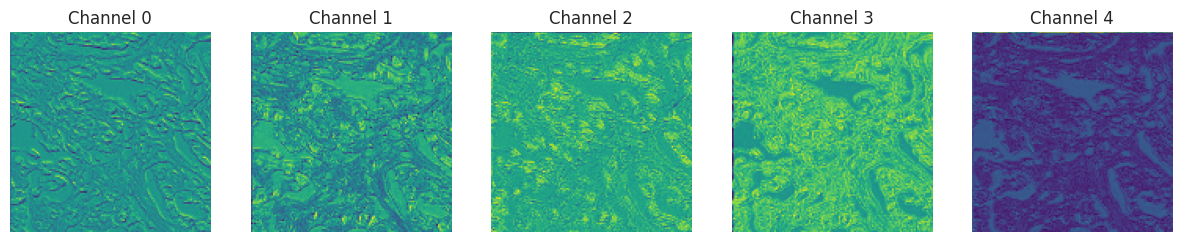

In [9]:
x = mu.view(mu.size(0), mu.size(1), 128, 128)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):  # Show first 5 channels
    axes[i].imshow(x[0, i].float().cpu().numpy(), cmap='viridis')
    axes[i].set_title(f'Channel {i}')
    axes[i].axis('off')

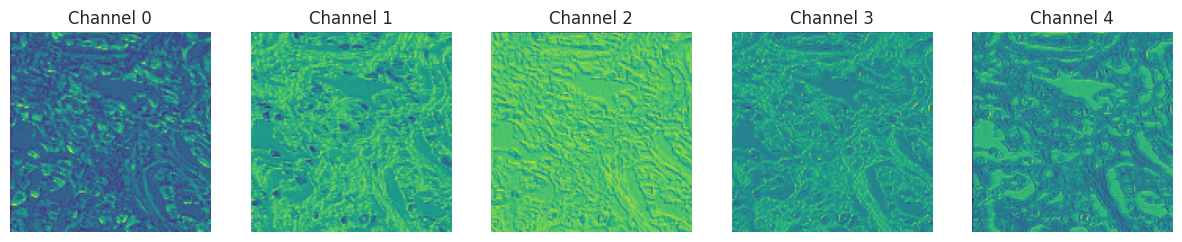

In [10]:
x = log_var.view(log_var.size(0), log_var.size(1), 128, 128)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):  # Show first 5 channels
    axes[i].imshow(x[0, i].float().cpu().numpy(), cmap='viridis')
    axes[i].set_title(f'Channel {i}')
    axes[i].axis('off')

In [11]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to(device, dtype=torch.bfloat16)

# 3. Instantiate the model
encoder = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)
ut.convert_model_to_bf16(vae)

# vae.eval()

# 4. Forward pass
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        encoded = encoder(test_patch_src_tensor)

# print("Input shape:", input_tensor.shape)
# print("Reconstructed shape:", reconstructed.shape)
print("Latent output shape:", encoded.shape)

Latent output shape: torch.Size([1, 64, 128, 128])


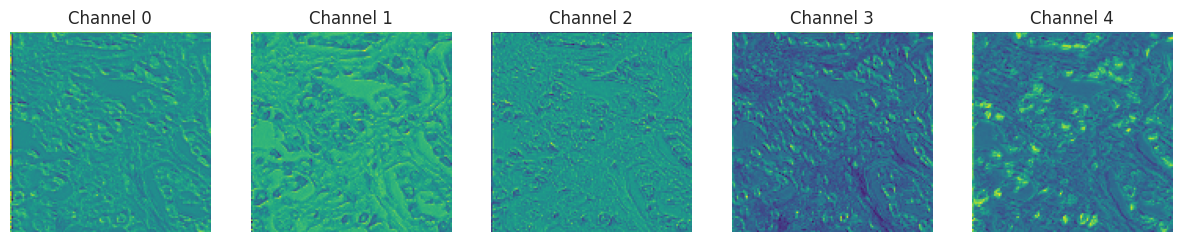

In [12]:
x = encoded

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):  # Show first 5 channels
    axes[i].imshow(x[0, i].float().cpu().numpy(), cmap='viridis')
    axes[i].set_title(f'Channel {i}')
    axes[i].axis('off')

In [13]:
extractor = StyleExtractor()
extractor = extractor.to(device='cuda', dtype=torch.bfloat16)
test_patch_dst_tensor = test_patch_dst_tensor.to(device='cuda', dtype=torch.bfloat16)

# 4. Forward pass
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        style_emb = extractor(test_patch_dst_tensor)

print("out shape: ", style_emb.shape)

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 64, 16384])
torch.Size([1, 16384, 64])
out shape:  torch.Size([1, 64, 16384])


BFloat16 is supported on this device


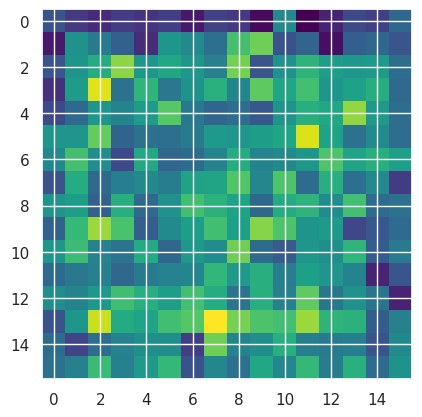

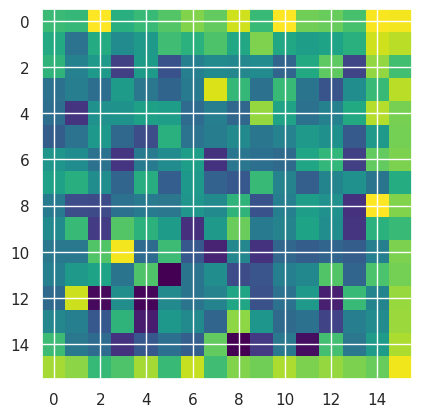

hs:  12


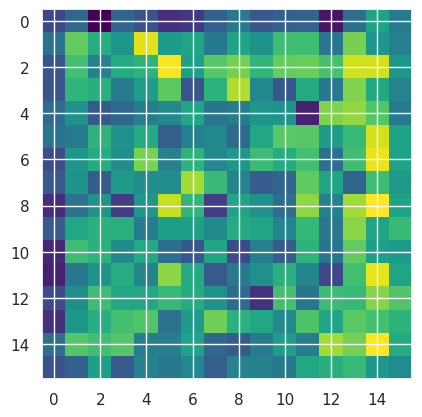

hs:  11


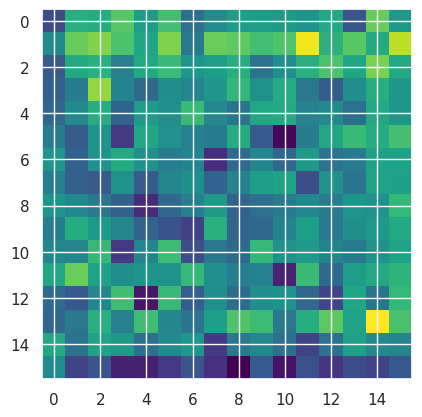

hs:  10


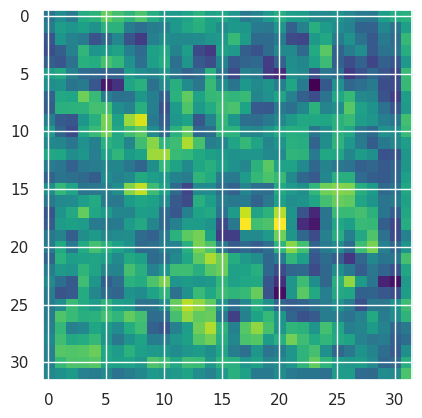

hs:  9


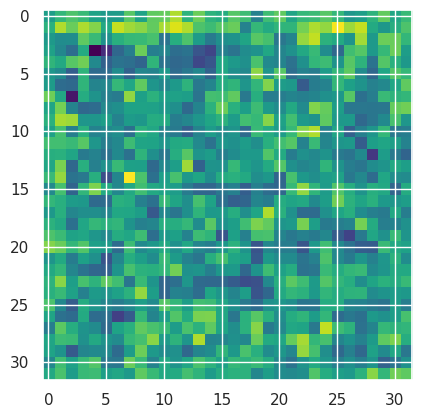

hs:  8


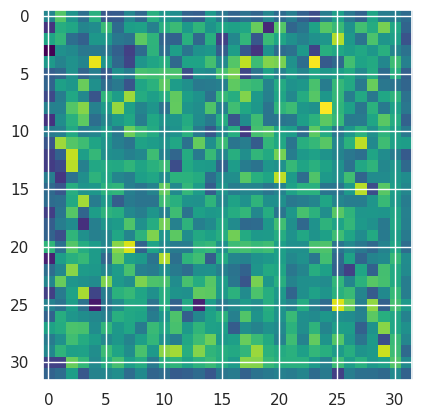

hs:  7


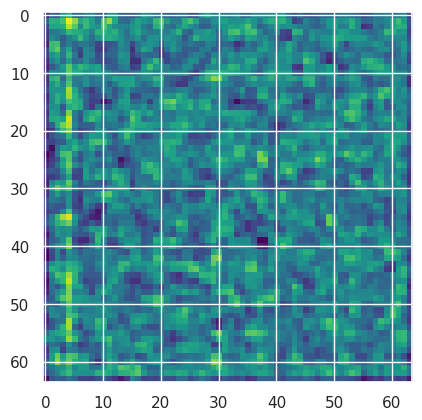

hs:  6


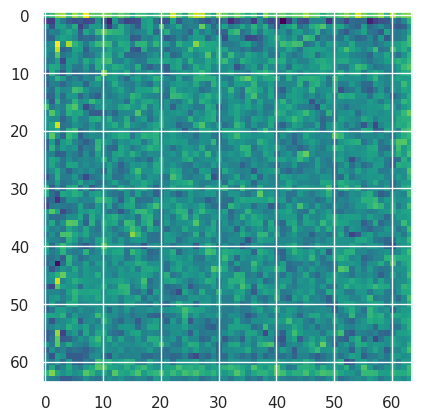

hs:  5


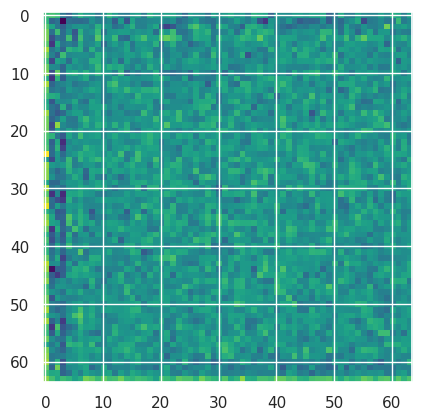

hs:  4


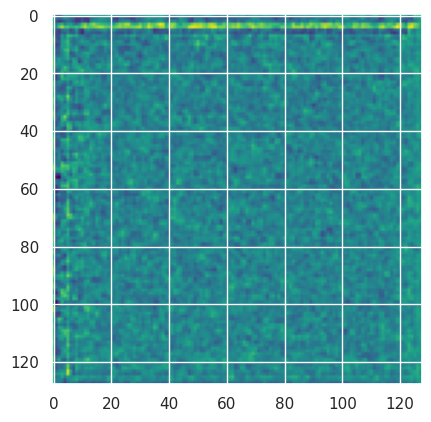

hs:  3


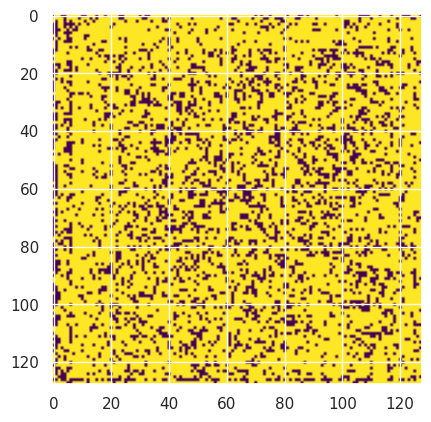

hs:  2


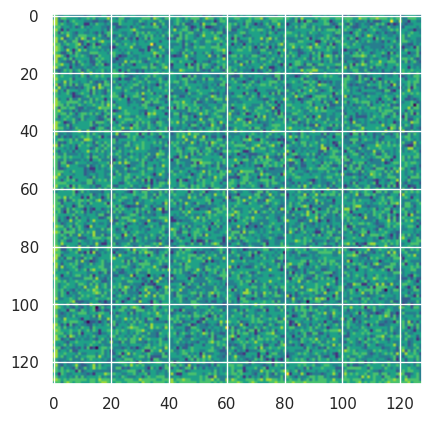

hs:  1


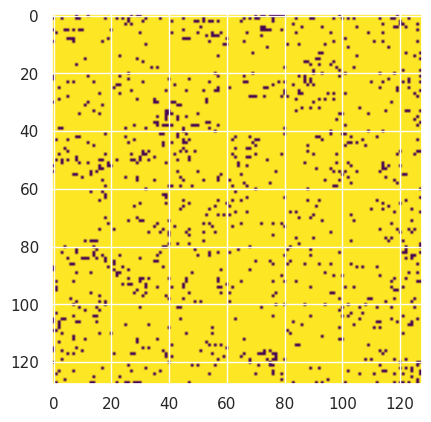

Input shape: torch.Size([1, 64, 128, 128])
Input dtype: torch.bfloat16
Output shape: torch.Size([1, 64, 128, 128])
Output dtype: torch.bfloat16
Model has 62294400 parameters


In [71]:
# -*- coding: utf-8 -*-
# Example of how to use the ImprovedUNet

import matplotlib.pyplot as plt

import torch
from osgen.utils import Utilities  # For the convert_to_bfloat16 utility

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if bfloat16 is supported
if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
    print("BFloat16 is supported on this device")
else:
    print("Warning: BFloat16 may not be fully supported on this device")

# Create model with matching in_channels
model = AdaINUNet(
    in_channels=64,  # Changed from 3 to 64 to match your input
    out_channels=3,
    time_emb_dim=128,
    base_channels=64,
    channel_mults=(1, 2, 4, 8),  # Creates a model with 4 resolution levels
    num_res_blocks=2,            # 2 residual blocks per resolution
    attention_resolutions=(4, 8),  # Add attention at 8×8 and 16×16 resolutions
    dropout=0.1,
    style_strength=1.0,
    device=device
).to(device)

# Convert model parameters to bfloat16
for param in model.parameters():
    param.data = Utilities.convert_to_bfloat16(param.data)

# Create some sample inputs
batch_size = 1
channels = 64  # This should match in_channels of the model
height, width = 128, 128

# Input tensor
x = encoded  # Make sure encoded has shape [1, 64, 128, 128]
x = Utilities.convert_to_bfloat16(x)

# Style tensor
style_flat = style_emb.to(device='cuda', dtype=torch.bfloat16)  # [1, 64, 16384]
style = style_flat.view(batch_size, channels, height, width)
style = Utilities.convert_to_bfloat16(style)

timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

# Forward pass
with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
    output = model(x, timesteps, style)

print(f"Input shape: {x.shape}")
print(f"Input dtype: {x.dtype}")
print(f"Output shape: {output.shape}")
print(f"Output dtype: {output.dtype}")
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

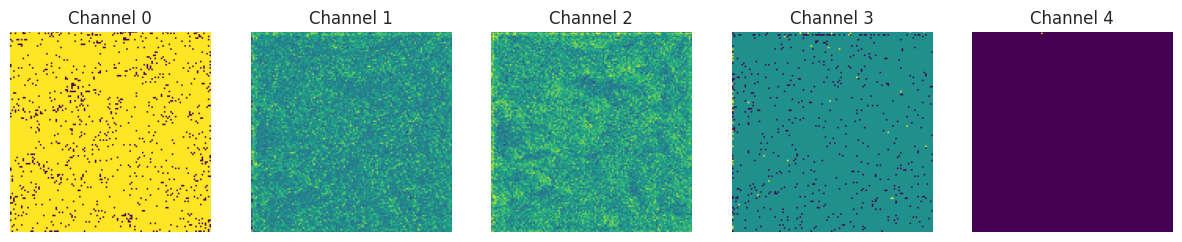

In [72]:
x = output.view(output.size(0), output.size(1), 128, 128)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):  # Show first 5 channels
    axes[i].imshow(x[0, i].float().detach().cpu().numpy(), cmap='viridis')
    axes[i].set_title(f'Channel {i}')
    axes[i].axis('off')